<a href="https://colab.research.google.com/github/surengunturumasters/deeplearning_final/blob/main/Unet_model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
gc.collect()

0

In [4]:
# https://www.kaggle.com/pierrenicolaspiquin/oct-segmentation/data
# Settings
input_path = os.path.join('/content/drive/MyDrive/2015_BOE_Chiu')
subject_path = [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] + [os.path.join(input_path, 'Subject_10.mat')]

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

subject_path

['/content/drive/MyDrive/2015_BOE_Chiu/Subject_01.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_02.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_03.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_04.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_05.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_06.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_07.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_08.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_09.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_10.mat']

In [5]:
mat = scipy.io.loadmat(subject_path[0])
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

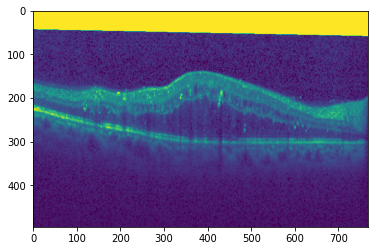

In [6]:
plt.imshow(img_array[25])

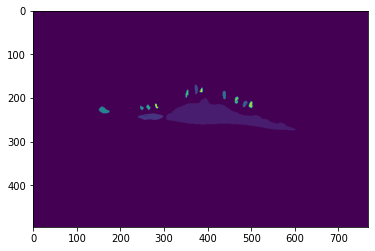

In [7]:
plt.imshow(manual_fluid_array[25])

In [8]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

In [9]:
thresh = np.vectorize(thresh, otypes=[np.float])

In [10]:
subject_path

['/content/drive/MyDrive/2015_BOE_Chiu/Subject_01.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_02.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_03.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_04.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_05.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_06.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_07.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_08.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_09.mat',
 '/content/drive/MyDrive/2015_BOE_Chiu/Subject_10.mat']

In [11]:
def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255
        img_array = resize(img_array, (img_array.shape[0], width, height))
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array  = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])


100%|██████████| 1/1 [00:08<00:00,  8.41s/it]


In [12]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))

### U-net

In [13]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

In [14]:
batch_size = 9
epochs = 100
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [15]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    dice = K.mean((2 * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [16]:
class UNet_1(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
      
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(mid_channel),
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(mid_channel),
                torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                )
        return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(mid_channel),
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(mid_channel),
                torch.nn.Conv2d(kernel_size=51, in_channels=mid_channel, out_channels=out_channels, padding=1),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
                )
        return  block


    def __init__(self, in_channel, out_channel):
        super(UNet_1, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)

        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=128, out_channels=256),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(256),
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=256),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(256),
                            torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode

        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)

        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool2)
        # Decode
        decode_block2 = self.crop_and_concat(bottleneck1, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

In [17]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet1(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [18]:
learning_rate = 0.01
unet1 = UNet_1(in_channel=1,out_channel=2)
if use_gpu:
    unet1 = unet1.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(unet1.parameters(), lr = 0.01, momentum=0.99)

In [19]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet1(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [20]:
def get_val_metric(x_val, y_val, func): 
    unet1.eval()
    x_val = torch.from_numpy(x_val).float().cpu()
    y_val = torch.from_numpy(y_val).long().cpu()

    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    #print("-----")
    outputs = unet1(x_val)#.reshape(y_val.shape)
    #print(outputs.resize([11, 196, 196]))
    y_val_adj = np.transpose(y_val.cpu().detach().numpy(),(0, 2,3,1))[:, :,:,0]
    return func(torch.tensor(y_val_adj), outputs.argmax(1).cpu().detach().numpy())

In [21]:
get_val_metric(x_val, y_val, iou_coef)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


<tf.Tensor: shape=(), dtype=float64, numpy=0.1408712149604792>

In [29]:
get_val_metric(x_val, y_val, dice_coef)

<tf.Tensor: shape=(), dtype=float64, numpy=0.2098794794232891>

In [22]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:490: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
 50%|█████     | 50/100 [24:48<25:30, 30.60s/it]

Total loss in epoch 50 : 0.6731123924255371 and validation loss : 0.5074151158332825


100%|██████████| 100/100 [49:36<00:00, 29.76s/it]

Total loss in epoch 100 : 0.674068808555603 and validation loss : 0.5064846873283386


In [23]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2])
    union = K.sum(y_true,[1,2])+K.sum(y_pred,[1,2])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2])
    union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
    dice = K.mean((2 * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [24]:
batch_train_x = torch.from_numpy(x_train[0 * batch_size : (0 + 1) * batch_size]).float()
batch_train_y = torch.from_numpy(y_train[0 * batch_size : (0 + 1) * batch_size]).long()

In [39]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet1(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

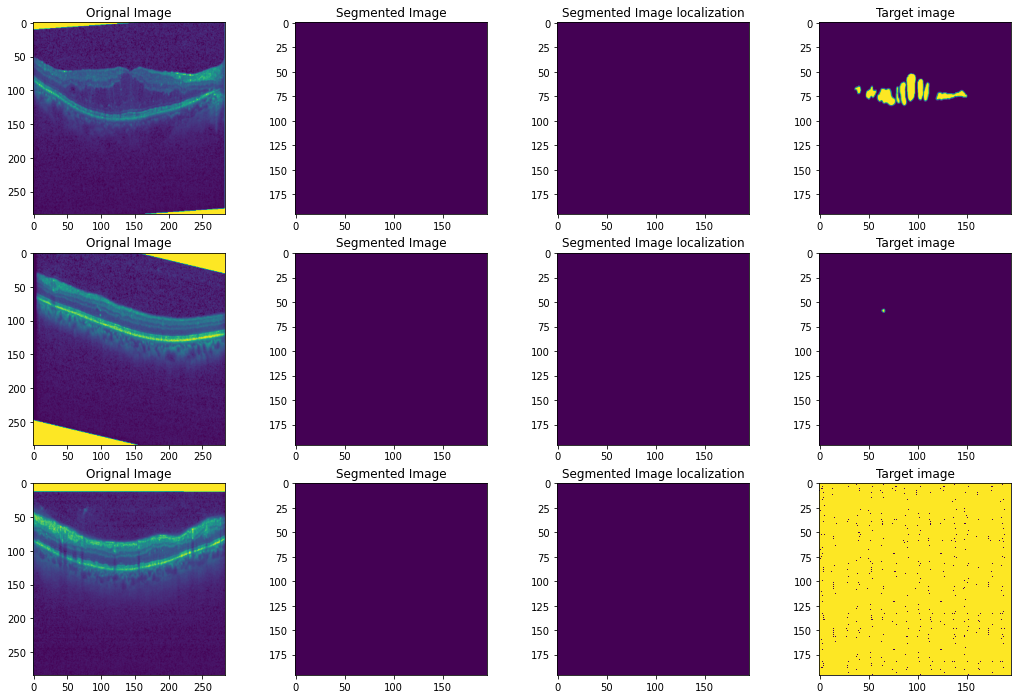

In [40]:
plot_examples(x_train, y_train)

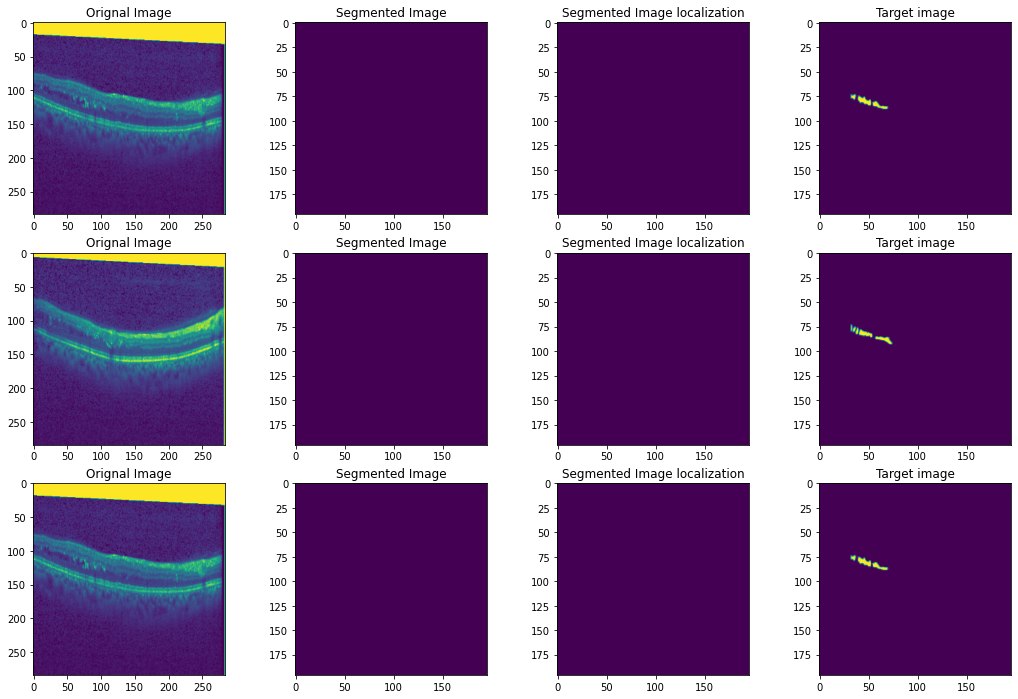

In [41]:
plot_examples(x_val, y_val)